In [1]:
import detectron2
import torch
import copy
import pickle 
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper   # the default mapper
from detectron2.data import build_detection_train_loader
from detectron2.data import build_detection_test_loader
from detectron2.data import detection_utils as utils 
from detectron2.data.detection_utils import annotations_to_instances
from tqdm import tqdm 

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/detectron2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#for the mapepr
import copy
import logging
import numpy as np
from typing import List, Optional, Union
import torch

from detectron2.config import configurable

from detectron2.data import detection_utils as utils 
import detectron2.data.transforms as T

In [3]:
torch.__version__

'1.10.0'

In [4]:
!nvidia-smi

Sat Jan 21 21:11:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   38C    P0    54W / 300W |   3578MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   

# Register the dataset so that it can be used by dataloader

In [5]:
def get_detectron_train_data():
    data = [] #here is where we will collect the coco dicts
    root = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Detectron_Detection/Data/DetectronData/"
    xml_files = [
        "327_A1d_ASAP.xml", # data good
        "270_A1d_ASAP.xml", #looks good
        "131_B1e_ASAP_fixed.xml" #data good, 
        "41_A2c_ASAP_fixed.xml" #good, 
        "51_D1b_ASAP_fixed.xml" #good
        
    ]
    for id in xml_files: #collect all of the individual WSI data 
        sample_id = id.split(".")[0]
        sample_data = None
        filepath = str(root + sample_id+".pickle")
        with open(filepath, 'rb') as handle:
            sample_data = pickle.load(handle)
        sample_data 
        for patch_info in sample_data:
            data.append(patch_info)
    return data


In [6]:
def get_detectron_test_data():
    data = [] #here is where we will collect the coco dicts
    root = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Detectron_Detection/Data/DetectronData/"
    xml_files = [
        "281_A1f_ASAP.xml", #looks good 

    ]
    for id in xml_files: #collect all of the individual WSI data 
        sample_id = id.split(".")[0]
        sample_data = None
        filepath = str(root + sample_id+".pickle")
        with open(filepath, 'rb') as handle:
            sample_data = pickle.load(handle)
        sample_data 
        for patch_info in sample_data:
            data.append(patch_info)
    return data


In [7]:
train_data = get_detectron_train_data()
test_data = get_detectron_test_data()

In [8]:
# new_data = test_data[15:]
# print(len(new_data))
# test_data = test_data[:15]
# for d in new_data:
#     train_data.append(d)

In [9]:
print(len(train_data), len(test_data))

305 40


In [10]:
DatasetCatalog.register("nuclei_detection_train", get_detectron_train_data)
DatasetCatalog.register("nuclei_detection_test", get_detectron_test_data)

In [11]:
MetadataCatalog.get("nuclei_detection_train").thing_classes = ["cell"] 
MetadataCatalog.get("nuclei_detection_test").thing_classes = ["cell"] 

In [12]:
# we create the train dataloader here. Might make sense to play around with batch_size.
train_dataloader = build_detection_train_loader(
    train_data,
    mapper=DatasetMapper(is_train=True,
                         augmentations=[ 
                         ], 
                         use_instance_mask = True, 
                         instance_mask_format = "polygon",
                         image_format="BGR"), 
    total_batch_size = 1, 
    )

In [13]:
# test_dataloader = build_detection_test_loader(
#     test_data,
#     mapper=DatasetMapper(    is_train= True,
#                          augmentations=[], 
#                          use_instance_mask = True, 
#                          instance_mask_format = "polygon",
#                          image_format="BGR"), 
#     )

In [14]:
data = []
num = 0 
for x in tqdm(train_dataloader):
    if num > 10:
        break 
    print(x[0]["instances"])
    data.append(x)
    num += 1

2it [00:00,  8.90it/s]

Instances(num_instances=15, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[ 15.4824, 118.4688,  31.6094, 137.3789],
        [ 29.5938, 118.4688,  36.4082, 133.6348],
        [ 90.4512,  90.6309, 109.2656, 117.7969],
        [113.1055,  72.9688, 123.8555,  87.5586],
        [ 17.1152,  43.4043,  29.4004,  55.8828],
        [ 59.6387,  12.9746,  74.1328,  32.3652],
        [163.7871,   9.7109, 176.0742,  29.9648],
        [142.2852,  49.7383, 164.9395,  72.9688],
        [162.2520,  62.0254, 181.9297,  87.8477],
        [146.8926,  78.8242, 166.4746,  98.6934],
        [195.5605, 104.2617, 214.7578, 120.0039],
        [213.8945,  26.9883, 222.2461,  35.5332],
        [191.9121, 134.1152, 203.2402, 148.0332],
        [192.0078, 151.1055, 201.4160, 168.0957],
        [128.3672, 169.0547, 155.2441, 186.2363]])), gt_classes: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), gt_masks: PolygonMasks(num_instances=15)])
Instances(num_instances=28, image_height=256, imag

4it [00:00,  7.68it/s]

Instances(num_instances=56, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[238.4863, 218.8086, 248.8574, 234.9863],
        [215.1543, 171.0020, 230.3984, 176.6016],
        [108.2441, 235.5781, 119.8672, 245.5391],
        [119.3477, 215.3418, 126.1973, 225.2012],
        [126.1973, 208.3906, 133.7715, 219.7012],
        [130.6602, 203.4102, 145.0840, 216.6914],
        [143.2148, 211.9180, 153.9043, 219.4941],
        [106.2734, 216.7949, 114.1602, 230.8047],
        [ 91.4336, 224.3711, 106.7930, 237.6543],
        [162.9316, 164.1836, 172.9980, 180.0605],
        [158.3652, 127.9688, 174.5547, 144.2598],
        [132.9414, 136.5820, 148.1973, 152.7695],
        [135.8477, 182.7598, 143.6309, 199.2578],
        [142.6973, 194.6934, 152.5547, 200.1934],
        [ 96.6230, 184.6270, 108.4531, 197.8066],
        [ 81.8867, 190.7480,  92.9902, 206.0039],
        [ 64.2461, 211.8145,  77.6328, 224.9941],
        [ 55.1152, 200.5039,  64.9727, 213.3711],
        [ 47.

6it [00:00,  7.19it/s]

Instances(num_instances=73, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[2.1660e+02, 2.3928e+02, 2.2990e+02, 2.4936e+02],
        [2.3583e+02, 2.3897e+02, 2.4612e+02, 2.4770e+02],
        [2.4040e+02, 2.1703e+02, 2.5350e+02, 2.2940e+02],
        [2.2835e+02, 2.2920e+02, 2.3812e+02, 2.3824e+02],
        [2.2346e+02, 2.0913e+02, 2.3448e+02, 2.2452e+02],
        [2.3417e+02, 1.9718e+02, 2.5569e+02, 2.0799e+02],
        [2.2647e+02, 1.8211e+02, 2.3635e+02, 1.9728e+02],
        [2.3219e+02, 1.7566e+02, 2.5371e+02, 1.8481e+02],
        [2.3188e+02, 1.6558e+02, 2.5132e+02, 1.7805e+02],
        [2.2211e+02, 1.5030e+02, 2.3937e+02, 1.5965e+02],
        [1.9539e+02, 1.3793e+02, 2.0828e+02, 1.4998e+02],
        [1.8801e+02, 1.2358e+02, 2.0215e+02, 1.3647e+02],
        [1.9602e+02, 1.0747e+02, 2.0787e+02, 1.2275e+02],
        [1.7907e+02, 1.0269e+02, 1.8957e+02, 1.1454e+02],
        [1.8749e+02, 9.0525e+01, 2.0038e+02, 1.0560e+02],
        [1.9924e+02, 7.5035e+01, 2.1327e+02

7it [00:01,  6.34it/s]

Instances(num_instances=61, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[  8.2578, 193.2969,  21.5996, 204.3496],
        [ 12.7363, 175.3711,  24.1895, 193.8926],
        [ 26.6797, 167.9043,  38.0313, 186.9238],
        [  5.3691, 159.1406,  25.8828, 172.0859],
        [ 13.8340, 141.5156,  27.6758, 162.1270],
        [  5.9668, 136.4355,  16.7207, 155.5547],
        [ 15.8242, 216.6973,  26.0820, 231.3359],
        [ 26.8789, 206.0430,  39.8242, 218.8887],
        [ 37.7324, 197.7754,  47.8887, 208.9297],
        [ 54.2617, 191.0059,  61.3320, 198.5742],
        [ 59.5410, 199.8691,  68.2031, 213.7090],
        [ 52.5703, 207.7344,  63.4238, 218.1914],
        [ 67.7051, 207.8340,  79.6543, 219.0879],
        [ 71.1914, 126.5781,  95.4883, 142.6094],
        [107.6367, 121.0020, 123.9688, 135.2422],
        [126.6563, 130.8594, 139.9004, 146.6934],
        [138.2070, 131.6563, 146.8711, 154.0625],
        [145.5762, 132.5527, 160.1152, 152.1699],
        [146.

9it [00:01,  7.45it/s]

Instances(num_instances=50, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[2.1309e+00, 2.4410e+02, 1.2580e+01, 2.5486e+02],
        [1.9256e+02, 2.3231e+02, 1.9831e+02, 2.3890e+02],
        [1.9155e+02, 1.9229e+02, 1.9806e+02, 1.9950e+02],
        [1.5637e+02, 1.8948e+02, 1.6670e+02, 2.0912e+02],
        [1.3713e+02, 2.0492e+02, 1.4946e+02, 2.2616e+02],
        [1.1188e+02, 2.0071e+02, 1.2791e+02, 2.1694e+02],
        [5.8559e+01, 2.0752e+02, 6.9381e+01, 2.2025e+02],
        [4.7533e+01, 2.0031e+02, 5.9359e+01, 2.2005e+02],
        [1.8871e+01, 2.1664e+02, 3.2701e+01, 2.3779e+02],
        [2.9300e-02, 2.2376e+02, 1.9572e+01, 2.4530e+02],
        [3.9516e+01, 1.8948e+02, 4.8637e+01, 1.9580e+02],
        [1.3859e+01, 1.8196e+02, 3.1600e+01, 1.9349e+02],
        [1.2651e+02, 1.5361e+02, 1.4593e+02, 1.7096e+02],
        [1.2975e+02, 1.4498e+02, 1.4230e+02, 1.5184e+02],
        [1.0759e+02, 1.4635e+02, 1.2838e+02, 1.5263e+02],
        [3.2193e+01, 1.6175e+02, 5.5135e+01

11it [00:01,  6.08it/s]

Instances(num_instances=120, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[113.5215, 185.0117, 123.4941, 201.3867],
        [ 89.3750, 194.0391,  99.1387, 205.7969],
        [ 94.3086, 207.4766, 103.1270, 219.5488],
        [ 85.4902, 204.8516,  95.0430, 217.1348],
        [ 75.2031, 215.8750,  96.0938, 225.6367],
        [ 71.4238, 220.7031,  79.1914, 230.3613],
        [ 71.4238, 228.5762,  91.3691, 240.1250],
        [ 68.9043, 240.3340,  82.4453, 250.7285],
        [ 59.3516, 240.0195,  71.8438, 250.3086],
        [ 38.2500, 233.1953,  50.8477, 247.0527],
        [ 47.4883, 225.7422,  67.8535, 243.2734],
        [ 25.9668, 227.9473,  34.1543, 238.0254],
        [ 73.8379, 194.0391,  83.3906, 204.7461],
        [ 76.4629, 206.0059,  84.8613, 216.8203],
        [ 63.7598, 207.7930,  75.4121, 219.4434],
        [ 59.5605, 217.5527,  66.0703, 225.4277],
        [ 63.2344, 192.6738,  73.7324, 211.5703],
        [ 45.9141, 199.8125,  62.8145, 211.5703],
        [ 42

# Visualize Training Data

In [15]:
from detectron2.utils.visualizer import ColorMode, Visualizer
data[0][0]

{'file_name': '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Detectron_Detection/Data/Images/131_B1e_ASAP_fixed_45.jpg',
 'height': 256,
 'width': 256,
 'image_id': '131_B1e_ASAP_fixed_45',
 'image': tensor([[[184, 202, 196,  ..., 242, 227, 240],
          [188, 204, 200,  ..., 225, 221, 200],
          [188, 203, 193,  ..., 218, 210, 194],
          ...,
          [176, 189, 187,  ..., 224, 221, 212],
          [184, 190, 189,  ..., 219, 219, 212],
          [192, 189, 188,  ..., 217, 224, 220]],
 
         [[146, 174, 174,  ..., 229, 212, 218],
          [154, 176, 175,  ..., 213, 209, 187],
          [157, 172, 162,  ..., 204, 201, 189],
          ...,
          [135, 148, 146,  ..., 210, 207, 200],
          [144, 151, 151,  ..., 209, 208, 201],
          [153, 152, 151,  ..., 206, 215, 209]],
 
         [[206, 233, 232,  ..., 255, 240, 253],
          [215, 236, 235,  ..., 243, 239, 219],
          [220, 

In [16]:
data[0][0]["instances"].gt_classes

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [17]:
data[0][0]["image"].shape

torch.Size([3, 256, 256])

In [18]:
img = cv2.imread(data[0][0]["file_name"])

<Figure size 1000x1000 with 0 Axes>

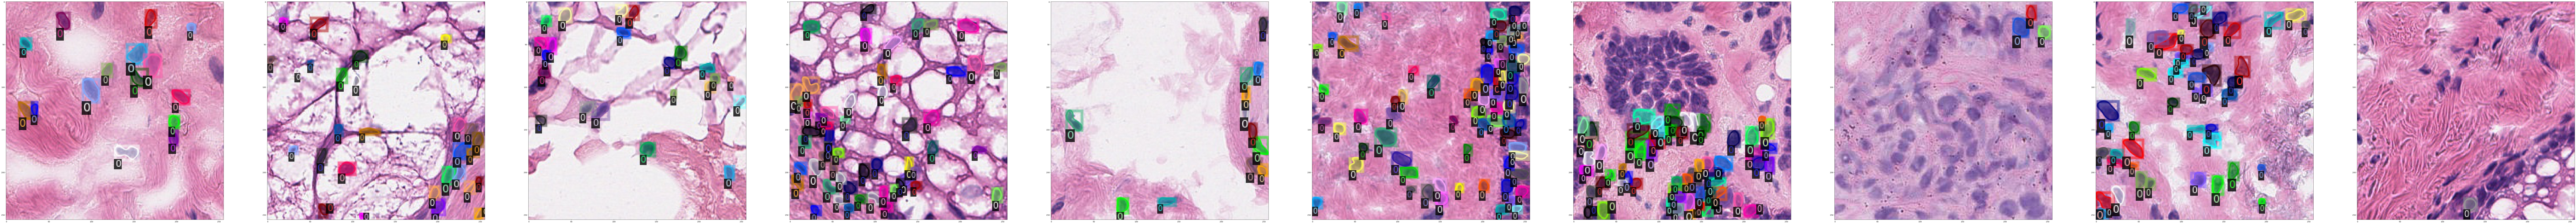

In [19]:
fig = plt.figure(figsize=(10, 10))
f, axarr = plt.subplots(1,10) 
f.set_size_inches(256, 256)
for i in range(len(data)-1):
    img = cv2.imread(data[i][0]["file_name"])
    v = Visualizer(img)
    v = v.overlay_instances(boxes=data[i][0]["instances"].gt_boxes, labels=data[i][0]["instances"].gt_classes.numpy(), masks=data[i][0]["instances"].gt_masks)
    axarr[i].imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
img = cv2.imread(data[0][0]["file_name"])
v = Visualizer(img)

In [21]:
v = v.overlay_instances(boxes=data[0][0]["instances"].gt_boxes, labels=data[0][0]["instances"].gt_classes.numpy(), masks=data[0][0]["instances"].gt_masks)

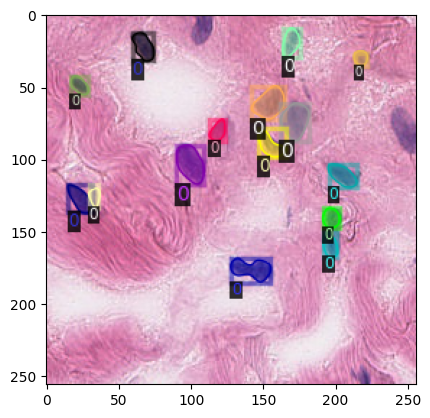

In [22]:
plt.imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))
plt.show()

# Training the Segmentation Model

In [23]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg

In [24]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = "nuclei_detection_train"
cfg.DATASETS.TEST = "nuclei_detection_test"
cfg.MODEL.DEVICE = "cuda"
cfg.DATALOADER.NUM_WORKERS = 20
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  # faster, and good enough for this toy dataset (default: 512)
cfg.SOLVER.BASE_LR = 2e-4
cfg.SOLVER.MAX_ITER = 10000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

In [25]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        mapper=DatasetMapper(is_train=True,
             augmentations=[ 
                    T.RandomBrightness(0.5, 2),
                    T.RandomContrast(0.5, 2),
                    T.RandomSaturation(0.5, 2),
                    T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                    T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
             ], 
             use_instance_mask = True, 
             instance_mask_format = "polygon",
             image_format="BGR"
        )
        return build_detection_train_loader(cfg, mapper=mapper)

In [26]:
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)

[01/21 21:13:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[01/21 21:13:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [RandomBrightness(intensity_min=0.5, intensity_max=2), RandomContrast(intensity_min=0.5, intensity_max=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomFlip(prob=0.5), RandomFlip(prob=0.5, horizontal=False, vertical=True)]
[01/21 21:13:15 d2.data.build]: Removed 0 images with no usable annotations. 305 images left.
[01/21 21:13:15 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    cell    | 16627        |
|            |              |
[01/21 21:13:15 d2.data.build]: Using training sampler TrainingSampler
[01/21 21:13:15 d2.data.common]: Serializing 305 elements to byte tensors and concatenating them all ...
[01/21 21:14:10 d2.data.common]: Serialized dataset takes 602.24 MiB
WARNING [01/21 21:14:10 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

In [27]:
trainer.train()

[01/21 21:14:11 d2.engine.train_loop]: Starting training from iteration 0


/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/detectron2/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/detectron2/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(t

[01/21 21:14:16 d2.utils.events]:  eta: 0:18:52  iter: 19  total_loss: 7.231  loss_cls: 0.6791  loss_box_reg: 0.3949  loss_mask: 0.6949  loss_rpn_cls: 4.82  loss_rpn_loc: 0.6407  time: 0.1270  data_time: 0.0937  lr: 3.9962e-06  max_mem: 1042M
[01/21 21:14:18 d2.utils.events]:  eta: 0:18:43  iter: 39  total_loss: 5.516  loss_cls: 0.6378  loss_box_reg: 0.4928  loss_mask: 0.691  loss_rpn_cls: 3.211  loss_rpn_loc: 0.5355  time: 0.1225  data_time: 0.0142  lr: 7.9922e-06  max_mem: 1042M
[01/21 21:14:21 d2.utils.events]:  eta: 0:18:56  iter: 59  total_loss: 4.009  loss_cls: 0.6009  loss_box_reg: 0.5389  loss_mask: 0.6834  loss_rpn_cls: 1.675  loss_rpn_loc: 0.4842  time: 0.1267  data_time: 0.0151  lr: 1.1988e-05  max_mem: 1042M
[01/21 21:14:24 d2.utils.events]:  eta: 0:19:03  iter: 79  total_loss: 3.125  loss_cls: 0.5571  loss_box_reg: 0.5487  loss_mask: 0.6713  loss_rpn_cls: 0.7589  loss_rpn_loc: 0.4767  time: 0.1267  data_time: 0.0136  lr: 1.5984e-05  max_mem: 1042M
[01/21 21:14:27 d2.utils.

[01/21 21:15:42 d2.utils.events]:  eta: 0:18:18  iter: 699  total_loss: 1.918  loss_cls: 0.3295  loss_box_reg: 0.573  loss_mask: 0.3731  loss_rpn_cls: 0.2974  loss_rpn_loc: 0.3262  time: 0.1256  data_time: 0.0105  lr: 0.00013986  max_mem: 1042M
[01/21 21:15:45 d2.utils.events]:  eta: 0:18:13  iter: 719  total_loss: 1.813  loss_cls: 0.349  loss_box_reg: 0.5528  loss_mask: 0.349  loss_rpn_cls: 0.329  loss_rpn_loc: 0.2944  time: 0.1252  data_time: 0.0100  lr: 0.00014386  max_mem: 1042M
[01/21 21:15:47 d2.utils.events]:  eta: 0:18:10  iter: 739  total_loss: 1.943  loss_cls: 0.3488  loss_box_reg: 0.5775  loss_mask: 0.3699  loss_rpn_cls: 0.3085  loss_rpn_loc: 0.3319  time: 0.1251  data_time: 0.0109  lr: 0.00014785  max_mem: 1042M
[01/21 21:15:49 d2.utils.events]:  eta: 0:18:08  iter: 759  total_loss: 1.867  loss_cls: 0.3448  loss_box_reg: 0.5427  loss_mask: 0.3689  loss_rpn_cls: 0.3062  loss_rpn_loc: 0.3099  time: 0.1248  data_time: 0.0098  lr: 0.00015185  max_mem: 1042M
[01/21 21:15:52 d2.u

[01/21 21:17:18 d2.utils.events]:  eta: 0:16:31  iter: 1379  total_loss: 1.801  loss_cls: 0.3196  loss_box_reg: 0.5389  loss_mask: 0.355  loss_rpn_cls: 0.2901  loss_rpn_loc: 0.3029  time: 0.1319  data_time: 0.0254  lr: 0.0002  max_mem: 1042M
[01/21 21:17:20 d2.utils.events]:  eta: 0:16:29  iter: 1399  total_loss: 1.814  loss_cls: 0.3253  loss_box_reg: 0.5362  loss_mask: 0.3591  loss_rpn_cls: 0.2924  loss_rpn_loc: 0.3236  time: 0.1317  data_time: 0.0105  lr: 0.0002  max_mem: 1042M
[01/21 21:17:23 d2.utils.events]:  eta: 0:16:25  iter: 1419  total_loss: 1.736  loss_cls: 0.3125  loss_box_reg: 0.5425  loss_mask: 0.3512  loss_rpn_cls: 0.2443  loss_rpn_loc: 0.2943  time: 0.1317  data_time: 0.0231  lr: 0.0002  max_mem: 1042M
[01/21 21:17:26 d2.utils.events]:  eta: 0:16:23  iter: 1439  total_loss: 1.777  loss_cls: 0.3009  loss_box_reg: 0.5457  loss_mask: 0.351  loss_rpn_cls: 0.2651  loss_rpn_loc: 0.2998  time: 0.1319  data_time: 0.0253  lr: 0.0002  max_mem: 1042M
[01/21 21:17:28 d2.utils.event

[01/21 21:18:44 d2.utils.events]:  eta: 0:14:57  iter: 2059  total_loss: 1.706  loss_cls: 0.2984  loss_box_reg: 0.5348  loss_mask: 0.3526  loss_rpn_cls: 0.2481  loss_rpn_loc: 0.2918  time: 0.1299  data_time: 0.0185  lr: 0.0002  max_mem: 1042M
[01/21 21:18:47 d2.utils.events]:  eta: 0:14:55  iter: 2079  total_loss: 1.75  loss_cls: 0.3009  loss_box_reg: 0.5486  loss_mask: 0.3516  loss_rpn_cls: 0.2657  loss_rpn_loc: 0.2973  time: 0.1298  data_time: 0.0138  lr: 0.0002  max_mem: 1042M
[01/21 21:18:49 d2.utils.events]:  eta: 0:14:49  iter: 2099  total_loss: 1.729  loss_cls: 0.2957  loss_box_reg: 0.5329  loss_mask: 0.3552  loss_rpn_cls: 0.2545  loss_rpn_loc: 0.2767  time: 0.1297  data_time: 0.0118  lr: 0.0002  max_mem: 1042M
[01/21 21:18:51 d2.utils.events]:  eta: 0:14:45  iter: 2119  total_loss: 1.63  loss_cls: 0.2809  loss_box_reg: 0.4951  loss_mask: 0.3393  loss_rpn_cls: 0.2481  loss_rpn_loc: 0.2763  time: 0.1296  data_time: 0.0142  lr: 0.0002  max_mem: 1042M
[01/21 21:18:54 d2.utils.event

[01/21 21:20:08 d2.utils.events]:  eta: 0:13:33  iter: 2739  total_loss: 1.567  loss_cls: 0.2889  loss_box_reg: 0.493  loss_mask: 0.3372  loss_rpn_cls: 0.246  loss_rpn_loc: 0.2686  time: 0.1279  data_time: 0.0097  lr: 0.0002  max_mem: 1042M
[01/21 21:20:11 d2.utils.events]:  eta: 0:13:31  iter: 2759  total_loss: 1.692  loss_cls: 0.2928  loss_box_reg: 0.513  loss_mask: 0.3355  loss_rpn_cls: 0.2243  loss_rpn_loc: 0.2922  time: 0.1281  data_time: 0.0432  lr: 0.0002  max_mem: 1042M
[01/21 21:20:14 d2.utils.events]:  eta: 0:13:28  iter: 2779  total_loss: 1.698  loss_cls: 0.3026  loss_box_reg: 0.5093  loss_mask: 0.3456  loss_rpn_cls: 0.2461  loss_rpn_loc: 0.2865  time: 0.1283  data_time: 0.0430  lr: 0.0002  max_mem: 1042M
[01/21 21:20:17 d2.utils.events]:  eta: 0:13:26  iter: 2799  total_loss: 1.602  loss_cls: 0.2945  loss_box_reg: 0.4605  loss_mask: 0.3391  loss_rpn_cls: 0.2647  loss_rpn_loc: 0.2615  time: 0.1284  data_time: 0.0213  lr: 0.0002  max_mem: 1042M
[01/21 21:20:20 d2.utils.events

[01/21 21:21:37 d2.utils.events]:  eta: 0:12:23  iter: 3419  total_loss: 1.611  loss_cls: 0.2578  loss_box_reg: 0.507  loss_mask: 0.346  loss_rpn_cls: 0.2274  loss_rpn_loc: 0.2727  time: 0.1281  data_time: 0.0499  lr: 0.0002  max_mem: 1042M
[01/21 21:21:39 d2.utils.events]:  eta: 0:12:20  iter: 3439  total_loss: 1.519  loss_cls: 0.2684  loss_box_reg: 0.4914  loss_mask: 0.3312  loss_rpn_cls: 0.2155  loss_rpn_loc: 0.2578  time: 0.1281  data_time: 0.0177  lr: 0.0002  max_mem: 1042M
[01/21 21:21:42 d2.utils.events]:  eta: 0:12:17  iter: 3459  total_loss: 1.599  loss_cls: 0.2507  loss_box_reg: 0.516  loss_mask: 0.3357  loss_rpn_cls: 0.2345  loss_rpn_loc: 0.2712  time: 0.1281  data_time: 0.0236  lr: 0.0002  max_mem: 1042M
[01/21 21:21:45 d2.utils.events]:  eta: 0:12:16  iter: 3479  total_loss: 1.633  loss_cls: 0.2888  loss_box_reg: 0.4784  loss_mask: 0.3399  loss_rpn_cls: 0.2308  loss_rpn_loc: 0.2839  time: 0.1281  data_time: 0.0208  lr: 0.0002  max_mem: 1042M
[01/21 21:21:47 d2.utils.events

[01/21 21:23:02 d2.utils.events]:  eta: 0:11:01  iter: 4099  total_loss: 1.536  loss_cls: 0.2534  loss_box_reg: 0.4887  loss_mask: 0.3258  loss_rpn_cls: 0.2155  loss_rpn_loc: 0.2687  time: 0.1275  data_time: 0.0231  lr: 0.0002  max_mem: 1042M
[01/21 21:23:05 d2.utils.events]:  eta: 0:10:58  iter: 4119  total_loss: 1.578  loss_cls: 0.2668  loss_box_reg: 0.511  loss_mask: 0.3413  loss_rpn_cls: 0.2427  loss_rpn_loc: 0.2533  time: 0.1275  data_time: 0.0192  lr: 0.0002  max_mem: 1042M
[01/21 21:23:08 d2.utils.events]:  eta: 0:10:55  iter: 4139  total_loss: 1.585  loss_cls: 0.2827  loss_box_reg: 0.4768  loss_mask: 0.3434  loss_rpn_cls: 0.2232  loss_rpn_loc: 0.2767  time: 0.1275  data_time: 0.0348  lr: 0.0002  max_mem: 1042M
[01/21 21:23:11 d2.utils.events]:  eta: 0:10:52  iter: 4159  total_loss: 1.619  loss_cls: 0.2711  loss_box_reg: 0.5046  loss_mask: 0.3401  loss_rpn_cls: 0.2289  loss_rpn_loc: 0.2787  time: 0.1277  data_time: 0.0577  lr: 0.0002  max_mem: 1042M
[01/21 21:23:16 d2.utils.even

[01/21 21:24:42 d2.utils.events]:  eta: 0:10:03  iter: 4779  total_loss: 1.648  loss_cls: 0.2801  loss_box_reg: 0.5359  loss_mask: 0.34  loss_rpn_cls: 0.2168  loss_rpn_loc: 0.2934  time: 0.1300  data_time: 0.0111  lr: 0.0002  max_mem: 1042M
[01/21 21:24:45 d2.utils.events]:  eta: 0:10:02  iter: 4799  total_loss: 1.618  loss_cls: 0.2851  loss_box_reg: 0.5282  loss_mask: 0.3286  loss_rpn_cls: 0.225  loss_rpn_loc: 0.2691  time: 0.1299  data_time: 0.0133  lr: 0.0002  max_mem: 1042M
[01/21 21:24:47 d2.utils.events]:  eta: 0:09:58  iter: 4819  total_loss: 1.576  loss_cls: 0.2626  loss_box_reg: 0.5023  loss_mask: 0.3407  loss_rpn_cls: 0.2199  loss_rpn_loc: 0.2723  time: 0.1299  data_time: 0.0085  lr: 0.0002  max_mem: 1042M
[01/21 21:24:49 d2.utils.events]:  eta: 0:09:55  iter: 4839  total_loss: 1.484  loss_cls: 0.2798  loss_box_reg: 0.4584  loss_mask: 0.3339  loss_rpn_cls: 0.2087  loss_rpn_loc: 0.2374  time: 0.1298  data_time: 0.0101  lr: 0.0002  max_mem: 1042M
[01/21 21:24:52 d2.utils.events

KeyboardInterrupt: 

# Inference using Model 

In [146]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .05
predictor = DefaultPredictor(cfg)

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

## Inference on test image

In [29]:
test_dataloader = build_detection_test_loader(
    test_data,
    mapper=DatasetMapper(    is_train= True,
                         augmentations=[], 
                         use_instance_mask = True, 
                         instance_mask_format = "polygon",
                         image_format="BGR"), 
    )

[01/21 21:25:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: []
[01/21 21:25:52 d2.data.common]: Serializing 40 elements to byte tensors and concatenating them all ...
[01/21 21:25:56 d2.data.common]: Serialized dataset takes 37.65 MiB


In [30]:
data = []
num = 0 
for x in tqdm(test_dataloader):
    if num > 10:
        break 
    print(x[0]["instances"])
    data.append(x)
    num += 1

  5%|████████▍                                                                                                                                                               | 2/40 [00:00<00:03, 11.09it/s]

Instances(num_instances=2, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[207.3105, 239.7017, 225.9141, 253.3442],
        [225.9141, 232.2603, 248.2383, 244.6626]])), gt_classes: tensor([0, 0]), gt_masks: PolygonMasks(num_instances=2)])
Instances(num_instances=21, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[ 92.5840, 160.2153, 116.3584, 192.1230],
        [117.6094, 155.8359, 140.1328, 178.9844],
        [134.5020, 140.8203, 151.3945, 163.9692],
        [152.6455, 135.1899, 175.1689, 159.5898],
        [195.1885, 120.1743, 220.8398, 145.8257],
        [215.8350, 130.1846, 238.9834, 162.7178],
        [212.7070, 155.8359, 235.2295, 180.2358],
        [232.1016, 183.3638, 250.2451, 202.1328],
        [219.5889, 198.3794, 242.1123, 226.5327],
        [200.8193, 179.6099, 228.3477, 207.1382],
        [175.7939, 136.4409, 200.8193, 157.0869],
        [192.6865, 143.9487, 215.2090, 173.3535],
        [164.5332, 152.0820, 193.3125, 177.1074],
    

 10%|████████████████▊                                                                                                                                                       | 4/40 [00:00<00:04,  7.97it/s]

Instances(num_instances=38, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[216.0049, 112.4146, 244.8291, 133.7197],
        [ 41.8047, 164.4238,  68.7490, 195.7549],
        [ 61.2295, 193.2485,  80.6553, 212.6738],
        [ 76.8955, 182.5957,  95.6934, 202.0210],
        [ 64.3633, 138.1060,  82.5352, 164.4238],
        [ 96.3203, 141.8657, 114.4922, 163.1704],
        [ 24.2754,  85.7642,  60.5625, 108.9131],
        [ 14.8916, 116.4204,  37.4141, 143.9487],
        [ 13.0146, 160.2153,  33.6602, 193.9995],
        [ 19.2705, 136.4409,  41.7939, 160.2153],
        [ 39.9170, 126.4307,  56.1836, 153.3335],
        [ 54.9316, 121.4258,  71.1982, 137.6924],
        [ 65.5684, 105.7847,  84.9629, 122.6768],
        [102.4805, 105.1592, 133.7627, 125.1797],
        [106.8604, 129.5591, 124.3779, 145.2002],
        [127.5059, 122.6768, 145.6494, 143.9487],
        [151.2803, 103.9077, 168.7979, 123.9282],
        [152.5313, 123.3027, 177.5576, 151.4565],
        [137.

 20%|█████████████████████████████████▌                                                                                                                                      | 8/40 [00:00<00:02, 13.69it/s]

Instances(num_instances=31, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[  1.5254,  60.1133,  21.5449,  83.8872],
        [  4.6533,  91.3950,  24.6738, 107.0361],
        [  2.7764, 103.2822,  32.1816, 119.5488],
        [  7.1553, 149.5796,  29.0527, 169.5996],
        [ 19.6680, 133.9385,  54.7041, 152.0820],
        [ 58.4580, 143.9487,  82.2324, 157.7129],
        [ 47.1963, 132.6870,  76.6016, 145.2002],
        [ 89.7402, 132.6870, 116.0166, 148.9536],
        [ 38.4375, 120.7998,  65.9658, 132.0615],
        [ 40.9404,  98.9028,  75.3506, 119.5488],
        [ 75.9756, 101.4053, 104.7549, 122.6768],
        [ 92.2422, 112.0410, 125.4014, 129.5591],
        [116.0166,  92.0205, 140.4170, 113.2925],
        [129.7803,  70.7490, 161.0625, 105.7847],
        [161.0625,  47.6006, 181.0830,  77.0054],
        [169.1963,  77.6309, 184.8369,  95.1489],
        [177.9551, 105.7847, 196.0986, 129.5591],
        [157.3086, 120.1743, 178.5801, 145.2002],
        [148.

 25%|█████████████████████████████████████████▊                                                                                                                             | 10/40 [00:01<00:03,  8.38it/s]

Instances(num_instances=60, image_height=256, image_width=256, fields=[gt_boxes: Boxes(tensor([[  5.1924, 150.2842,  22.0684, 169.0347],
        [ 14.5684, 162.1597,  35.8184, 188.4102],
        [ 42.6934, 150.2842,  68.9443, 178.4102],
        [ 67.0693, 169.6597,  85.8193, 187.7852],
        [ 52.0693, 187.7852,  79.5693, 202.1646],
        [  7.6934, 190.9102,  28.3184, 214.0356],
        [ 72.6943, 232.1611, 102.0703, 254.0366],
        [ 78.9443, 217.7861, 103.3203, 235.2861],
        [107.0703, 221.5361, 135.8203, 241.5361],
        [146.4463, 211.5356, 170.1963, 237.1611],
        [145.1963, 175.2847, 167.0713, 196.5352],
        [132.0713, 193.4102, 150.8213, 207.7856],
        [122.0703, 174.6597, 150.1963, 194.6602],
        [173.3213, 177.7852, 194.5723, 192.1602],
        [179.5713, 150.9092, 198.9473, 172.1597],
        [199.5723, 152.1592, 220.8223, 167.1597],
        [190.1973, 165.9097, 223.3223, 187.1602],
        [209.5723, 198.4106, 233.9482, 220.2856],
        [168.

 28%|█████████████████████████████████████████████▉                                                                                                                         | 11/40 [00:01<00:03,  7.76it/s]


<Figure size 1000x1000 with 0 Axes>

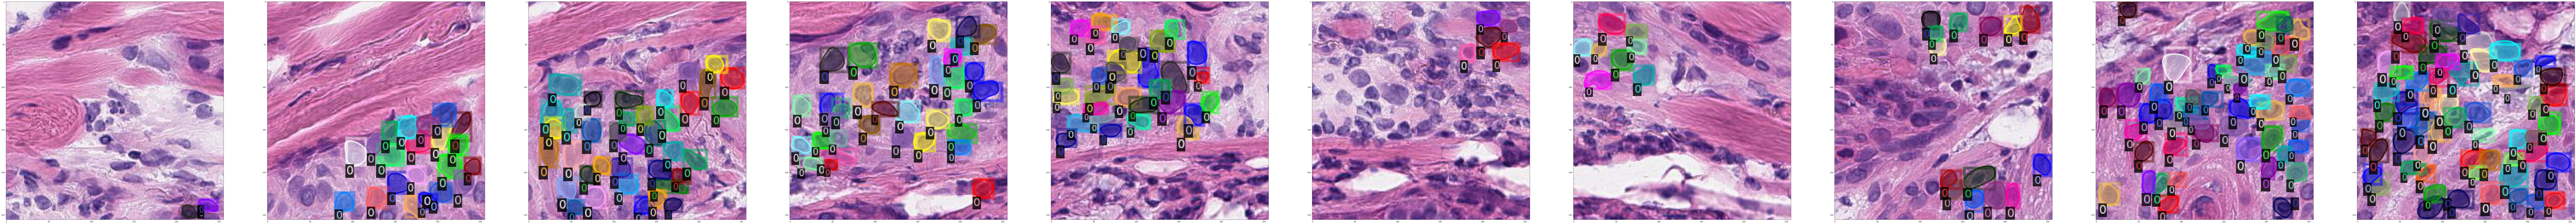

In [31]:
fig = plt.figure(figsize=(10, 10))
f, axarr = plt.subplots(1,10) 
f.set_size_inches(256, 256)
for i in range(len(data)-1):
    img = cv2.imread(data[i][0]["file_name"])
    v = Visualizer(img)
    v = v.overlay_instances(boxes=data[i][0]["instances"].gt_boxes, labels=data[i][0]["instances"].gt_classes.numpy(), masks=data[i][0]["instances"].gt_masks)
    axarr[i].imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))
plt.show()

In [168]:
img = cv2.imread(data[3][0]["file_name"])
v = Visualizer(img)

In [169]:
v = v.overlay_instances(boxes=data[3][0]["instances"].gt_boxes, labels=data[3][0]["instances"].gt_classes.numpy(), masks=data[3][0]["instances"].gt_masks)

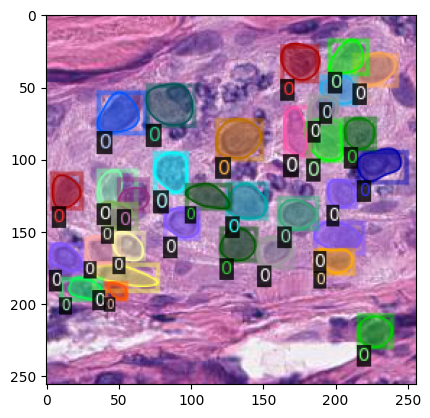

In [170]:
plt.imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))
plt.show()

In [171]:
outputs = predictor(img) # now predict on this image 

In [172]:
len(outputs["instances"])

100

In [173]:
outputs["instances"]._fields

{'pred_boxes': Boxes(tensor([[2.0861e+02, 1.2641e+01, 2.5232e+02, 5.1498e+01],
         [8.5343e+00, 4.3199e+01, 2.5581e+02, 2.5537e+02],
         [8.4632e+01, 4.0217e+01, 2.4405e+02, 1.0861e+02],
         [1.9422e+02, 3.6156e+01, 2.5048e+02, 1.8693e+02],
         [2.1079e+02, 2.1264e+01, 2.5597e+02, 6.7076e+01],
         [1.1080e+02, 7.1867e+01, 1.5681e+02, 1.0133e+02],
         [1.7857e+02, 1.9845e+02, 2.4578e+02, 2.2717e+02],
         [5.3042e+01, 4.3114e+01, 2.1559e+02, 1.7879e+02],
         [1.3866e+02, 9.6491e+01, 1.8948e+02, 1.2264e+02],
         [7.4132e+01, 1.2935e+02, 1.4486e+02, 1.5813e+02],
         [1.1440e+02, 4.5094e+01, 1.6086e+02, 9.3037e+01],
         [1.1535e+02, 6.1750e+01, 1.4566e+02, 1.0833e+02],
         [1.3544e+02, 1.8810e+02, 2.3703e+02, 2.1004e+02],
         [1.1913e+02, 1.2873e+02, 1.4660e+02, 1.6916e+02],
         [1.3688e+02, 1.3361e+02, 2.5235e+02, 2.1136e+02],
         [1.1383e+02, 5.6820e+01, 1.8347e+02, 9.7882e+01],
         [3.3017e+01, 4.6168e+01, 7.

In [174]:
outputs = outputs["instances"].to("cpu")

In [175]:
areas = outputs._fields["pred_boxes"].area()
bool_array = []
for i in range(len(areas)):
    if areas[i] < 30**2: 
        bool_array.append(True)
    else:
        bool_array.append(False)
bool_array = torch.tensor(bool_array)

In [176]:
outputs._fields["pred_boxes"][bool_array]

Boxes(tensor([[231.8697,  40.0367, 255.5275,  66.5267],
        [192.2817, 105.8105, 216.4978, 131.1392],
        [143.6793,  68.5568, 150.9103,  77.1853],
        [197.8143, 102.1311, 218.8013, 125.5000],
        [115.2089, 151.2872, 145.8467, 168.2977],
        [152.8454,   3.3455, 190.8221,  15.5169],
        [206.2402, 105.6020, 214.9664, 115.1696],
        [  0.4183, 238.4589,  19.4122, 244.9866],
        [119.0937,  79.6187, 147.6055,  99.0874],
        [ 70.0737, 205.7215,  90.3679, 213.0242],
        [165.1330, 108.9204, 186.2915, 128.0195],
        [141.8298,  62.1556, 151.9370,  77.4514],
        [153.0831, 100.7282, 178.1394, 114.8086],
        [164.2108,  62.4282, 180.2538,  92.4215],
        [152.4464, 107.0468, 186.4767, 124.0331],
        [137.4887, 104.0809, 171.3979, 122.8635],
        [157.8463, 105.2198, 175.6624, 114.6465],
        [153.5670,  98.7216, 171.1321, 107.5778],
        [148.2706, 151.4077, 169.0726, 170.9380],
        [ 43.8377, 151.5440,  66.9879, 166.6

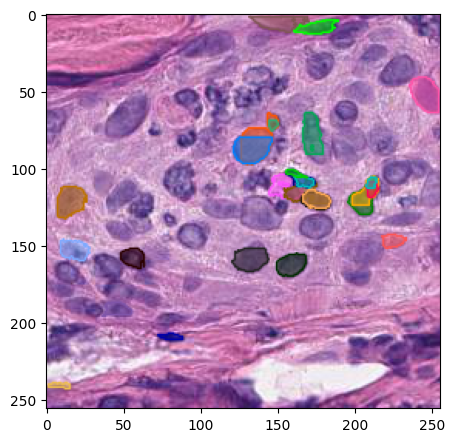

In [178]:
plt.figure(figsize=(512/100, 512/100))

v = Visualizer(img, scale=1)
v._default_font_size = 5
# v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# v = v.overlay_instances(masks = outputs["instances"]._fields["pred_masks"].to("cpu"))
v = v.overlay_instances(masks = outputs._fields["pred_masks"][bool_array])

plt.imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))

plt.show()

## Inference on test dataset

In [62]:
# from detectron2.evaluation import DatasetEvaluator
# from detectron2.evaluation import inference_on_dataset

In [165]:
 #import the COCO Evaluator to use the COCO Metrics
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

directory = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Detectron_Detection/output/"

In [166]:
#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator("nuclei_detection_test", cfg, False, output_dir="./output")
val_loader = build_detection_test_loader(cfg, "nuclei_detection_test")

WARNING [01/21 21:36:41 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[01/21 21:36:41 d2.evaluation.coco_evaluation]: Trying to convert 'nuclei_detection_test' to COCO format ...
WARNING [01/21 21:36:41 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/nuclei_detection_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[01/21 21:36:43 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    cell    | 1036         |
|            |              |
[01/21 21:36:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/21 21:36:43 d2.data.common]: Serializing 40 elements to byte tensors and concatenating them all ...
[01/21 21:36:46 d2

In [167]:
#Use the created predicted model in the previous step
inference_on_dataset(predictor.model, val_loader, evaluator)

[01/21 21:36:46 d2.evaluation.evaluator]: Start inference on 40 batches
[01/21 21:36:48 d2.evaluation.evaluator]: Inference done 11/40. Dataloading: 0.0008 s/iter. Inference: 0.0385 s/iter. Eval: 0.0121 s/iter. Total: 0.0514 s/iter. ETA=0:00:01
[01/21 21:36:51 d2.evaluation.evaluator]: Total inference time: 0:00:03.018546 (0.086244 s / iter per device, on 1 devices)
[01/21 21:36:51 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.041737 s / iter per device, on 1 devices)
[01/21 21:36:51 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/21 21:36:51 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[01/21 21:36:51 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[01/21 21:36:51 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[01/21 21:36:51 d2.evaluation.fast_eval_api]: COCOeval

OrderedDict([('bbox',
              {'AP': 0.0011658084406401257,
               'AP50': 0.008842636984881854,
               'AP75': 0.0,
               'APs': 0.0036149099859818755,
               'APm': 0.0,
               'APl': nan}),
             ('segm',
              {'AP': 0.0,
               'AP50': 0.0,
               'AP75': 0.0,
               'APs': 0.0,
               'APm': 0.0,
               'APl': nan})])

In [32]:
!nvidia-smi

Tue Jan 17 23:14:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   34C    P0    51W / 300W |  11271MiB / 32768MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   